# Learning to Dampen the Duffing Oscillator

In this notebook we will explore training a neural network to dampen a Simple Harmonic Oscillator

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import copy
import desolver as de
import torch

Using `autoray` backend


## Specifying the Dynamical System

Now let's specify the right hand side of our dynamical system. It should be

$$
\ddot x + \delta\dot x + \alpha x + \beta x^3 = \gamma\cos(\omega t)
$$

But desolver only works with first order differential equations, thus we must cast this into a first order system before we can solve it. Thus we obtain the following system

$$
\begin{array}{l}
\frac{\mathrm{d}x}{\mathrm{dt}} = v_x \\
\frac{\mathrm{d}v_x}{\mathrm{dt}} = -\delta v_x - \alpha x - \beta x^3 + \gamma\cos(\omega t)
\end{array}
$$

In [2]:
@de.rhs_prettifier(
    equ_repr="[vx, -k*x/m]",
    md_repr=r"""
$$
\frac{\mathrm{d}y}{\mathrm{dt}} = \begin{bmatrix}
   0            & 1 \\
   -\frac{k}{m} & 0
   \end{bmatrix} \cdot \vec y
$$
"""
)
def rhs(t, state, k, m, **kwargs):
    return torch.tensor([[0.0, 1.0], [-k/m,  0.0]], dtype=state.dtype, device=state.device)@state

In [3]:
print(rhs)
display(rhs)


$$
\frac{\mathrm{d}y}{\mathrm{dt}} = \begin{bmatrix}
   0            & 1 \\
   -\frac{k}{m} & 0
   \end{bmatrix} \cdot \vec y
$$




$$
\frac{\mathrm{d}y}{\mathrm{dt}} = \begin{bmatrix}
   0            & 1 \\
   -\frac{k}{m} & 0
   \end{bmatrix} \cdot \vec y
$$


Let's specify the initial conditions as well

In [4]:
y_init = torch.tensor([1., 0.], dtype=torch.float64)

And now we're ready to integrate!

## The Numerical Integration

We will use the same constants from Wikipedia as our constants where the forcing amplitude increases and all the other parameters stay constants.

In [5]:
#Let's define the fixed constants

constants = dict(
    k = 1.0,
    m = 1.0
)

# The period of the system
T = 2*torch.pi*(constants['m']/constants['k'])**0.5

# Initial and Final integration times
t0 = 0.0
tf = 40 * T

In [6]:
a = de.OdeSystem(rhs, y0=y_init, dense_output=True, t=(t0, tf), dt=0.0001, rtol=1e-12, atol=1e-12, constants={**constants})
a.method = "RK87"
a.integrate()

## Plotting the State and Phase Portrait

In [7]:
# Times to evaluate the system at
eval_times = torch.linspace(0.0, 40.0, 1000, device=a.y[-1].device, dtype=a.y[-1].dtype)*T

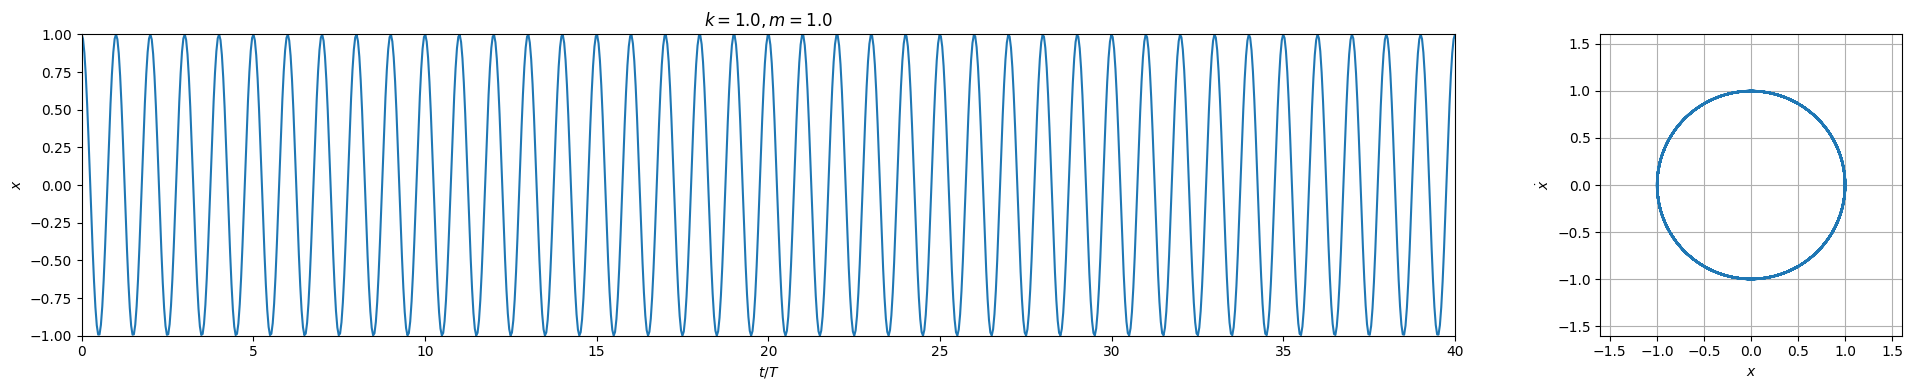

In [8]:
from matplotlib import gridspec

fig = plt.figure(figsize=(20, 4))

gs  = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
ax1.set_aspect(1)

ax0.plot(eval_times/T, a.sol(eval_times)[:, 0])
ax0.set_xlim(0.0, 40.0)
ax0.set_ylim(-1.0, 1.0)
ax0.set_xlabel(r"$t/T$")
ax0.set_ylabel(r"$x$")
ax0.set_title(r"$k={},m={}$".format(a.constants['k'], a.constants['m']))

ax1.plot(a.y[:, 0], a.y[:, 1])
ax1.set_xlim(-1.6, 1.6)
ax1.set_ylim(-1.6, 1.6)
ax1.set_xlabel(r"$x$")
ax1.set_ylabel(r"$\dot x$")
ax1.grid(which='major')
plt.tight_layout()

## Defining a Simple Neural Network

Now we can define a simple neural network, in this case a feed-forward network (or a dense network), to dampen the oscillations of the system. Specifically, we will treat the network as providing some continuous force `F` which will be applied at every timestep assuming no lag in the controller nor any discretisation issues

In [9]:
@de.rhs_prettifier(
    equ_repr="[vx, -k*x/m+NN(x)/m]",
    md_repr=r"""
$$
\frac{\mathrm{d}y}{\mathrm{dt}} = \begin{bmatrix}
   0            & 1 \\
   -\frac{k}{m} & 0
   \end{bmatrix} \cdot \vec y + \begin{bmatrix}
    0 \\
    \mathcal{NN}(x)/m
   \end{bmatrix}
$$
"""
)
def nn_rhs(t, state, k, m, nn_controller, **kwargs):
    base_dynamics_rhs = rhs(t, state, k, m)
    neural_network_impulse = nn_controller(state)[...,0]
    neural_network_impulse = torch.stack([
        torch.zeros_like(neural_network_impulse),
        neural_network_impulse/m
    ])
    return base_dynamics_rhs + neural_network_impulse

In [10]:
print(nn_rhs)
display(nn_rhs)


$$
\frac{\mathrm{d}y}{\mathrm{dt}} = \begin{bmatrix}
   0            & 1 \\
   -\frac{k}{m} & 0
   \end{bmatrix} \cdot \vec y + \begin{bmatrix}
    0 \\
    \mathcal{NN}(x)/m
   \end{bmatrix}
$$




$$
\frac{\mathrm{d}y}{\mathrm{dt}} = \begin{bmatrix}
   0            & 1 \\
   -\frac{k}{m} & 0
   \end{bmatrix} \cdot \vec y + \begin{bmatrix}
    0 \\
    \mathcal{NN}(x)/m
   \end{bmatrix}
$$


In [11]:
state_dim = y_init.shape[0]
hidden_dim = 32
output_dim = 1

simple_nn = torch.nn.Sequential(
    torch.nn.Linear(state_dim, hidden_dim),
    torch.nn.GELU(),
    torch.nn.Linear(hidden_dim, hidden_dim),
    torch.nn.GELU(),
    torch.nn.Linear(hidden_dim, output_dim),
).to('cuda' if torch.cuda.is_available() else 'cpu')


optimizer = torch.optim.AdamW(simple_nn.parameters(), lr=4e-3, weight_decay=1e-2)
number_of_steps = 512

y_init = y_init.to('cuda' if torch.cuda.is_available() else 'cpu', torch.float32)

def closure():
    optimizer.zero_grad()
    integrated_system = de.solve_ivp(nn_rhs, t_span=(t0, tf), y0=y_init, method='RK87', args=(constants['k'], constants['m'], simple_nn))
    # The loss is the integrated error over the timespan.
    # This penalises the network for taking more time to dampen the system
    loss = torch.sum((integrated_system.t[1:] * integrated_system.y[0,1:].square()) * torch.diff(integrated_system.t))
    loss = 0.1*loss + 0.9*integrated_system.y[-1,0].square()
    if loss.requires_grad:
        loss.backward()
    return loss

best_loss = torch.inf
best_params = copy.deepcopy(simple_nn.state_dict())

for step_idx in range(number_of_steps):
    loss = optimizer.step(closure).item()
    if loss < best_loss:
        best_loss = loss
        best_params = copy.deepcopy(simple_nn.state_dict())
    print(f"[{step_idx+1}/{number_of_steps}] - loss: {loss:.4e}, best_loss: {best_loss:.4e}")

[1/512] - loss: 1.0276e+02, best_loss: 1.0276e+02
[2/512] - loss: 3.6690e+01, best_loss: 3.6690e+01
[3/512] - loss: 2.2941e+01, best_loss: 2.2941e+01
[4/512] - loss: 1.4030e+01, best_loss: 1.4030e+01
[5/512] - loss: 7.8588e+00, best_loss: 7.8588e+00
[6/512] - loss: 4.0314e+00, best_loss: 4.0314e+00
[7/512] - loss: 2.3058e+00, best_loss: 2.3058e+00
[8/512] - loss: 2.2212e+00, best_loss: 2.2212e+00
[9/512] - loss: 3.1359e+00, best_loss: 2.2212e+00
[10/512] - loss: 4.4046e+00, best_loss: 2.2212e+00
[11/512] - loss: 5.4471e+00, best_loss: 2.2212e+00
[12/512] - loss: 5.9278e+00, best_loss: 2.2212e+00
[13/512] - loss: 5.7600e+00, best_loss: 2.2212e+00
[14/512] - loss: 5.0671e+00, best_loss: 2.2212e+00
[15/512] - loss: 4.0472e+00, best_loss: 2.2212e+00
[16/512] - loss: 2.9402e+00, best_loss: 2.2212e+00
[17/512] - loss: 1.9815e+00, best_loss: 1.9815e+00
[18/512] - loss: 1.3024e+00, best_loss: 1.3024e+00
[19/512] - loss: 9.6044e-01, best_loss: 9.6044e-01
[20/512] - loss: 9.6575e-01, best_loss: 

In [12]:
simple_nn.load_state_dict(best_params)

with torch.no_grad():
    a_nn = de.OdeSystem(nn_rhs, y0=y_init, dense_output=True, t=(t0, tf), rtol=1e-7, atol=1e-7, constants={**constants, "nn_controller": simple_nn})
    a_nn.method = "RK87"
    a_nn.integrate()

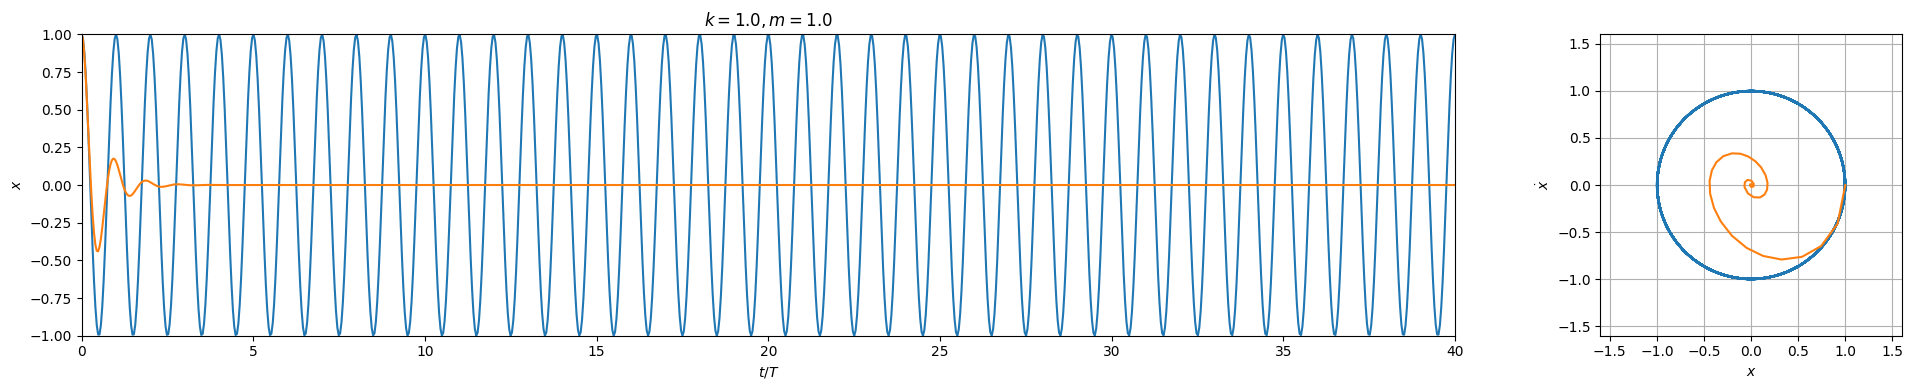

In [13]:
fig = plt.figure(figsize=(20, 4))

gs  = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
ax1.set_aspect(1)

ax0.plot(eval_times/T, a.sol(eval_times)[:, 0], label="Without NN")
ax0.plot(eval_times/T, a_nn.sol(eval_times.to(a_nn.y)).cpu()[:, 0], label="With NN")
ax0.set_xlim(0.0, 40.0)
ax0.set_ylim(-1.0, 1.0)
ax0.set_xlabel(r"$t/T$")
ax0.set_ylabel(r"$x$")
ax0.set_title(r"$k={},m={}$".format(a.constants['k'], a.constants['m']))

ax1.plot(a.y[:, 0], a.y[:, 1], label="Without NN")
ax1.plot(a_nn.y[:, 0].cpu(), a_nn.y[:, 1].cpu(), label="With NN")
ax1.set_xlim(-1.6, 1.6)
ax1.set_ylim(-1.6, 1.6)
ax1.set_xlabel(r"$x$")
ax1.set_ylabel(r"$\dot x$")
ax1.grid(which='major')
plt.tight_layout()